In [2]:
import os
import re
import glob
import pandas as pd
from utils import set_font

from PIL import Image

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
set_font()

In [4]:
tf.__version__

'2.0.0'

In [6]:
tf.test.is_gpu_available()

InternalError: cudaGetDevice() failed. Status: cudaGetErrorString symbol not found.

In [6]:
df_meta = pd.read_csv('data/meta.csv')
df_meta.head()

,filetype,class1,class2,class3,filepath
0,properties,구이,구이,갈비구이,E:/Data/kfood\구이\구이\갈비구이\crop_area.properties
1,jpg,구이,구이,갈비구이,E:/Data/kfood\구이\구이\갈비구이\Img_000_0000.jpg
2,jpg,구이,구이,갈비구이,E:/Data/kfood\구이\구이\갈비구이\Img_000_0001.jpg
3,jpg,구이,구이,갈비구이,E:/Data/kfood\구이\구이\갈비구이\Img_000_0002.jpg
4,jpg,구이,구이,갈비구이,E:/Data/kfood\구이\구이\갈비구이\Img_000_0003.jpg


In [4]:
df_meta.shape

(150910, 5)

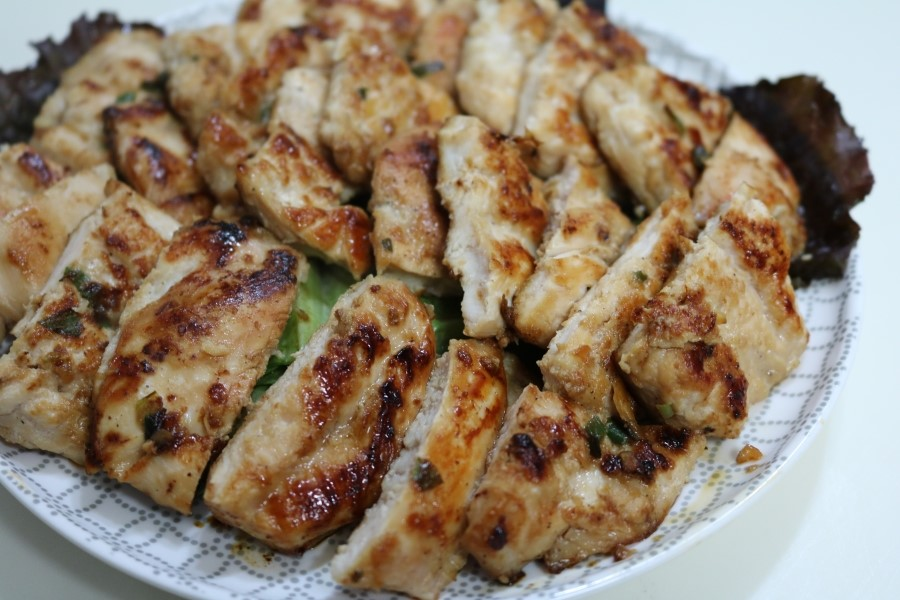

In [5]:
for image_path in df_meta.filepath[1:2]:
    display(Image.open(str(image_path)))

In [8]:
df = pd.DataFrame({'id':df_meta[df_meta.filetype=='jpg'].filepath, 'label':df_meta[df_meta.filetype=='jpg'].class1})
df = df.sample(frac=0.2, random_state=1)
df['subset'] = np.where(df.index.isin(np.random.choice(df.index, int(df.shape[0]*0.7))), 'train', 'validation')
df.shape

(29567, 3)

In [9]:
image_count = df[df.subset=='train'].shape[0]
CLASS_NAMES = np.unique(df.label.values)
CLASS_NAMES

array(['구이', '국', '기타', '김치', '나물', '떡', '만두', '면', '무침', '밥', '볶음', '쌈',
       '음청류', '장', '장아찌', '적', '전', '전골', '조림', '죽', '찌개', '찜', '탕', '튀김',
       '한과', '해물', '회'], dtype=object)

## Slow

In [10]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_data_gen = image_generator.flow_from_dataframe(dataframe=df,
                                                     directory='/',
                                                     x_col='id',
                                                     y_col='label',
                                                     subset='training',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     classes = list(CLASS_NAMES))

Found 20697 validated image filenames belonging to 27 classes.


In [13]:
valid_data_gen = image_generator.flow_from_dataframe(dataframe=df,
                                                     directory='/',
                                                     x_col='id',
                                                     y_col='label',
                                                     subset='validation',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     classes = list(CLASS_NAMES))

Found 8870 validated image filenames belonging to 27 classes.


In [14]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

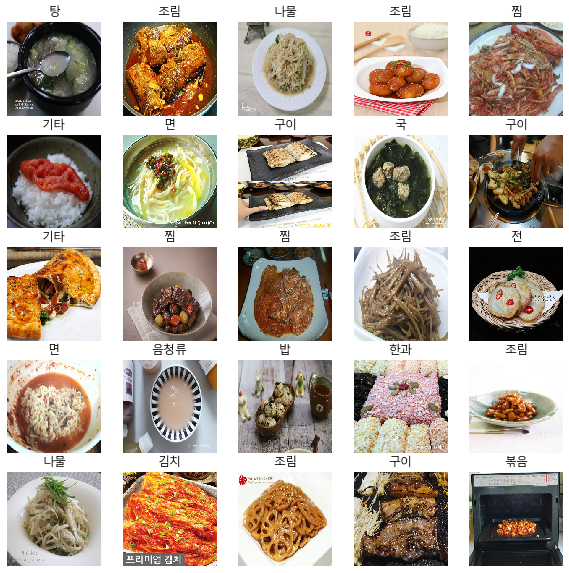

In [15]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [16]:
IMG_SHAPE = (224, 224, 3)
# IMG_HEIGHT = 224
# IMG_WIDTH = 224
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [18]:
base_model.trainable = False

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
prediction_layer = keras.layers.Dense(27)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 27)


In [22]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 27)                34587     
Total params: 2,292,571
Trainable params: 34,587
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
len(model.trainable_variables)

2

In [26]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(valid_data_gen, steps = validation_steps)

20/20 [==============================] - 25s 1s/step - loss: 8.5517 - accuracy: 0.0172


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 8.55
initial accuracy: 0.02


In [ ]:
history = model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=valid_data_gen)

E:\Anaconda\envs\tf2\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
E:\Anaconda\envs\tf2\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 6. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
E:\Anaconda\envs\tf2\lib\site-packages\PIL\TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Train for 647 steps, validate for 278 steps
Epoch 1/10
472/647 [====================>.........] - ETA: 3:51 - loss: 8.5142 - accuracy: 0.0376

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fast Laod

In [15]:
list_ds = tf.data.Dataset.list_files(df.id.values)

In [34]:

list_ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [85]:
for f in list_ds.take(5):
    parts = tf.strings.split(f, os.path.sep)
    print(parts[3].numpy())
    print(parts[3].numpy() == CLASS_NAMES)
#   print(f.numpy())

b'\xeb\xb3\xb6\xec\x9d\x8c'
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
b'\xeb\xb0\xa5'
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
b'\xeb\xa9\xb4'
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
b'\xed\x83\x95'
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
b'\xea\xb5\xad'
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


In [51]:
'd'==np.array(['a','b','c','d'])

array([False, False, False,  True])

In [86]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second is the class-directory
  return parts[3].numpy() == CLASS_NAMES

In [87]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [88]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [89]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

AttributeError: 'Tensor' object has no attribute 'numpy'

In [75]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  False


In [27]:
## 학습을 위한 기본 메소드

In [70]:
CLASS_NAMES==np.array(['a'])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])